In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50
from tensorflow.keras.datasets import mnist, cifar10, cifar100
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import mean_squared_error

In [ ]:
NUM_CLASSES = 100
WIDTH = 32
NUM_CHANNELS = 3
NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_DEV = 100

BASE_DIR = f""

In [ ]:
opt = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

### Utils

In [ ]:
# load train and test dataset (cifar100)
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar100.load_data()
	trainX = trainX.reshape((trainX.shape[0], 32, 32, 3))
	testX = testX.reshape((testX.shape[0], 32, 32, 3))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# set highest (probability) value in vector to 1, and all others to 0
def set_max_to_one(a):
    idx = a.argmax(axis=1)
    return (idx[:,None] == np.arange(a.shape[1])).astype(float)

# accuracy computation with one-hot encoded multi-class label vectors
def acc_ohe(Y, Y_pred):
    n = Y.shape[0]
    ohe_dim = Y.shape[1]
    return ((Y == Y_pred).sum(axis=1) == ohe_dim).sum() / n

In [ ]:
def fcn(inp_dim, out_dim):
    inp = keras.layers.Input(shape=inp_dim)
    x = keras.layers.Flatten()(inp)  # redundant for embeddings
    out = keras.layers.Dense(out_dim, activation='sigmoid')(x)
    return keras.models.Model(inp, out)

In [ ]:
def get_memorization_estimate(X_train, Y_train, n_runs=2000, subset_ratio=0.7, save_dir=None, X_test=None, Y_test=None, get_influence=False):
  n = X_train.shape[0]
  m = int(subset_ratio*n)

  subset_idx_list = []
  h_k_pred_list = []
  if get_influence:
    h_k_pred_list_te = []
  for k in range(n_runs):
    print(f"Run {k+1} of {n_runs}")
    subset_idx = np.random.choice(n, m, replace=False)
    subset_idx_list.append(subset_idx)
    X_tr = X_train[subset_idx]
    Y_tr = Y_train[subset_idx]

    # model hardcoded here, rather than passed as parameter
    try:  # if model already exists (helps with out of memory crashes, as well as further estimate improvement)
      h_k = tf.keras.models.load_model(f"{save_dir}/c100_0_h{k}.h5")
    except:
      h_k = fcn(inp_dim=X_tr.shape[1], out_dim=Y_tr.shape[1])
      h_k.compile(optimizer=opt, loss=loss, metrics=metrics)
      h_k.fit(X_tr, Y_tr, epochs=100, batch_size=4096, shuffle=True, validation_split=0.1, verbose=0)
    if save_dir:
      h_k.save(f"{save_dir}/c100_0_h{k}.h5")

    # predict on entire data rather than just current training (sub)set
    h_k_pred = h_k.predict(X_train)
    h_k_pred_list.append(h_k_pred)

    if get_influence:
      h_k_pred_te = h_k.predict(X_test)
      h_k_pred_list_te.append(h_k_pred_te)

    if Y_test is not None:
      print(f"Accuracy (Train): {acc_ohe(Y_train, set_max_to_one(h_k_pred))}")
      print(f"Accuracy (Test): {acc_ohe(Y_test, set_max_to_one(h_k.predict(X_test)))}")


  h_k_pred_arr = np.array(h_k_pred_list)
  trainset_mask = np.zeros((n_runs, n), dtype=bool)
  for k in range(n_runs):
    trainset_mask[k][subset_idx_list[k]] = True
  inv_mask = np.logical_not(trainset_mask)

  mem_list = []
  if get_influence:
    n_class = Y_test.shape[1]
    n_train = Y_train.shape[0]
    n_test = Y_test.shape[0]
    inf_arr = np.zeros((n_train, n_test))
    h_k_pred_arr_te = np.array(h_k_pred_list_te)
  for i in range(n):
    if ~(i%500):
      print(i)
    # assuming one-hot encoded labels
    y_i = Y_train[i].argmax()
    mask_i = trainset_mask[:,i]
    inv_mask_i = inv_mask[:,i]

    # we want probability of predicting correct class by a model on average
    # h_k_pred_arr of shape (n_runs, n_train_instances, n_classes)
    mem_i = (h_k_pred_arr[:,i,y_i][mask_i]).mean() - (h_k_pred_arr[:,i,y_i][inv_mask_i]).mean()
    mem_list.append(mem_i)

    if get_influence:
      for j in range(n_test):
        y_j = Y_test[j].argmax()
        inf_arr[i, j] = (h_k_pred_arr_te[:,j,y_j][mask_i]).mean() - (h_k_pred_arr_te[:,j,y_j][inv_mask_i]).mean()

  if get_influence:
    return np.array(mem_list), inf_arr

  return np.array(mem_list)

### Data Loading

In [ ]:
X_train, Y_train, X_test, Y_test = load_dataset()
X_train, X_test = prep_pixels(X_train, X_test)

169001437/169001437 [==============================] - 10s 0us/step


In [ ]:
MODEL_DIR = f""
model = keras.models.load_model(f"{MODEL_DIR}/resnet50_cifar100.h5")

In [ ]:
X_emb_tr_pae = model.predict(X_train)
X_emb_tr_penult = tf.keras.models.Model(model.inputs, model.layers[-3].output).predict(X_train)
# X_emb_tr_penult_bn = tf.keras.models.Model(model.inputs, model.layers[-2].output).predict(X_train)   # makes results even worse

X_emb_te_pae = model.predict(X_test)
X_emb_te_penult = tf.keras.models.Model(model.inputs, model.layers[-3].output).predict(X_test)
# X_emb_te_penult_bn = tf.keras.models.Model(model.inputs, model.layers[-2].output).predict(X_test)

print(X_emb_tr_pae.shape, X_emb_tr_penult.shape, X_emb_te_pae.shape, X_emb_te_penult.shape)

313/313 [==============================] - 32s 99ms/step
(50000, 100) (50000, 256) (10000, 100) (10000, 256)


### Self-influence (also called memorization) computation using last/penultimate layer

In [ ]:
estimates = get_memorization_estimate(X_emb_tr_penult, Y_train, n_runs=500, save_dir=f"{BASE_DIR}/saved", X_test=X_emb_te_penult, Y_test=Y_test)

Run 1 of 500
1563/1563 [==============================] - 2s 1ms/step
Accuracy (Train): 0.79372
313/313 [==============================] - 0s 1ms/step
Accuracy (Test): 0.7234
Run 2 of 500
1563/1563 [==============================] - 2s 1ms/step
Accuracy (Train): 0.79244
313/313 [==============================] - 0s 1ms/step
Accuracy (Test): 0.7215
Run 3 of 500
1563/1563 [==============================] - 2s 1ms/step
Accuracy (Train): 0.7927
313/313 [==============================] - 0s 1ms/step
Accuracy (Test): 0.722
Run 4 of 500
1563/1563 [==============================] - 2s 1ms/step
Accuracy (Train): 0.79074
313/313 [==============================] - 0s 1ms/step
Accuracy (Test): 0.7181
Run 5 of 500
1563/1563 [==============================] - 2s 1ms/step
Accuracy (Train): 0.79372
313/313 [==============================] - 0s 1ms/step
Accuracy (Test): 0.7199
Run 6 of 500
1563/1563 [==============================] - 2s 1ms/step
Accuracy (Train): 0.79316
313/313 [======================

In [ ]:
valid_est = estimates[~np.isnan(estimates)]
print(valid_est.shape)

(50000,)


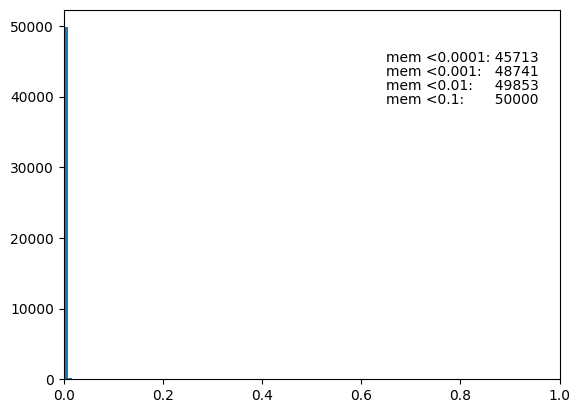

In [ ]:
valid_est_tmp = valid_est.copy()
valid_est_tmp[(valid_est_tmp<0) & (valid_est_tmp>-0.1) ] = 0
plt.hist(valid_est_tmp, bins=5)
plt.text(0.65, 45000, f"mem <0.0001: {(np.abs(valid_est_tmp)<0.0001).sum()}")
plt.text(0.65, 43000, f"mem <0.001:   {(np.abs(valid_est_tmp)<0.001).sum()}")
plt.text(0.65, 41000, f"mem <0.01:     {(np.abs(valid_est_tmp)<0.01).sum()}")
plt.text(0.65, 39000, f"mem <0.1:       {(np.abs(valid_est_tmp)<0.1).sum()}")
plt.xlim((0,1))
plt.savefig(f"{BASE_DIR}/c100_mem_last.pdf")

## First layer estimates

https://pluskid.github.io/influence-memorization/

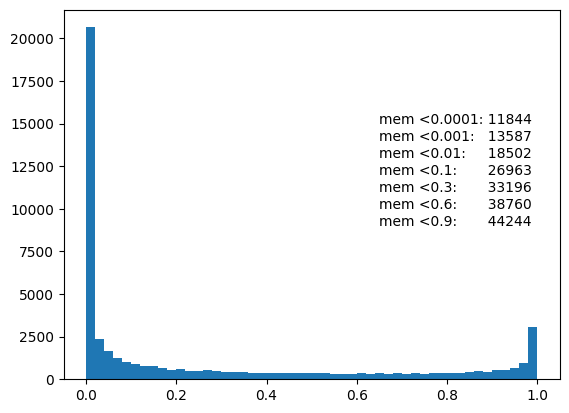

In [ ]:
str_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']
label_dict = {i: str_labels[i] for i in range(len(str_labels))}

MEM_DIR = f""
cifar100_inf = np.load(BASE_DIR + "/cifar100_high_infl_pairs_infl0.15_mem0.25.npz", allow_pickle=True)
cifar100_infl_matrix_class = np.load(BASE_DIR + "/cifar100_infl_matrix.npz", allow_pickle=True)

# from Memorization Paper (so _mp)
tr_labels_mp = cifar100_infl_matrix_class['tr_labels']
tr_ix_mp = np.array(range(len(tr_labels_mp)))
tr_mem_mp = cifar100_infl_matrix_class['tr_mem']

tt_labels_mp = cifar100_infl_matrix_class['tt_labels']
tt_ix_mp = np.array(range(len(tt_labels_mp)))

# memorization values for each training instance based on our indexing
tr_ix_mp_aligned = tr_ix_mp  # alignment required for imagenet only
tr_mp_ix_mem = {i:m for i,m in zip(tr_ix_mp_aligned, tr_mem_mp)}

plt.hist(tr_mem_mp, bins=50)
plt.text(0.65, 15000, f"mem <0.0001: {(np.abs(tr_mem_mp)<0.0001).sum()}")
plt.text(0.65, 14000, f"mem <0.001:   {(np.abs(tr_mem_mp)<0.001).sum()}")
plt.text(0.65, 13000, f"mem <0.01:     {(np.abs(tr_mem_mp)<0.01).sum()}")
plt.text(0.65, 12000, f"mem <0.1:       {(np.abs(tr_mem_mp)<0.1).sum()}")
plt.text(0.65, 11000, f"mem <0.3:       {(np.abs(tr_mem_mp)<0.3).sum()}")
plt.text(0.65, 10000, f"mem <0.6:       {(np.abs(tr_mem_mp)<0.6).sum()}")
plt.text(0.65, 9000, f"mem <0.9:       {(np.abs(tr_mem_mp)<0.9).sum()}")
plt.savefig(f"{BASE_DIR}/c100_mem_inp.pdf")

### Memorization and Influence Computation

In [ ]:
# almost 100 training instance influence estimated per minute (with full 10k test set)
# so reducing test set size for now
# at least some instance from each class with 500 test instances
mem_est, inf_est = get_memorization_estimate(X_emb_tr_penult, Y_train, n_runs=500, save_dir=f"{BASE_DIR}/saved", X_test=X_emb_te_penult[:500], Y_test=Y_test[:500], get_influence=True)

In [ ]:
# np.save(f"{BASE_DIR}/c100_inf_lastlayer_500.npy", inf_est, allow_pickle=True)
# np.save(f"{BASE_DIR}/c100_mem_lastlayer_500.npy", mem_est, allow_pickle=True)

In [ ]:
inf_est = np.load(f"{BASE_DIR}/c100_inf_lastlayer_500.npy", allow_pickle=True)
mem_est = np.load(f"{BASE_DIR}/c100_mem_lastlayer_500.npy", allow_pickle=True)

In [ ]:
import seaborn as sns
rcParams_ticks = {'figure.dpi': 200.0, 'xtick.bottom': True, 'ytick.left': False, 'legend.loc': 'lower right', 'legend.fancybox': True,
                  'axes.edgecolor': 'grey', 'axes.xmargin': 0.05, 'text.usetex': False}
sns.set_theme(style='ticks', rc=rcParams_ticks)

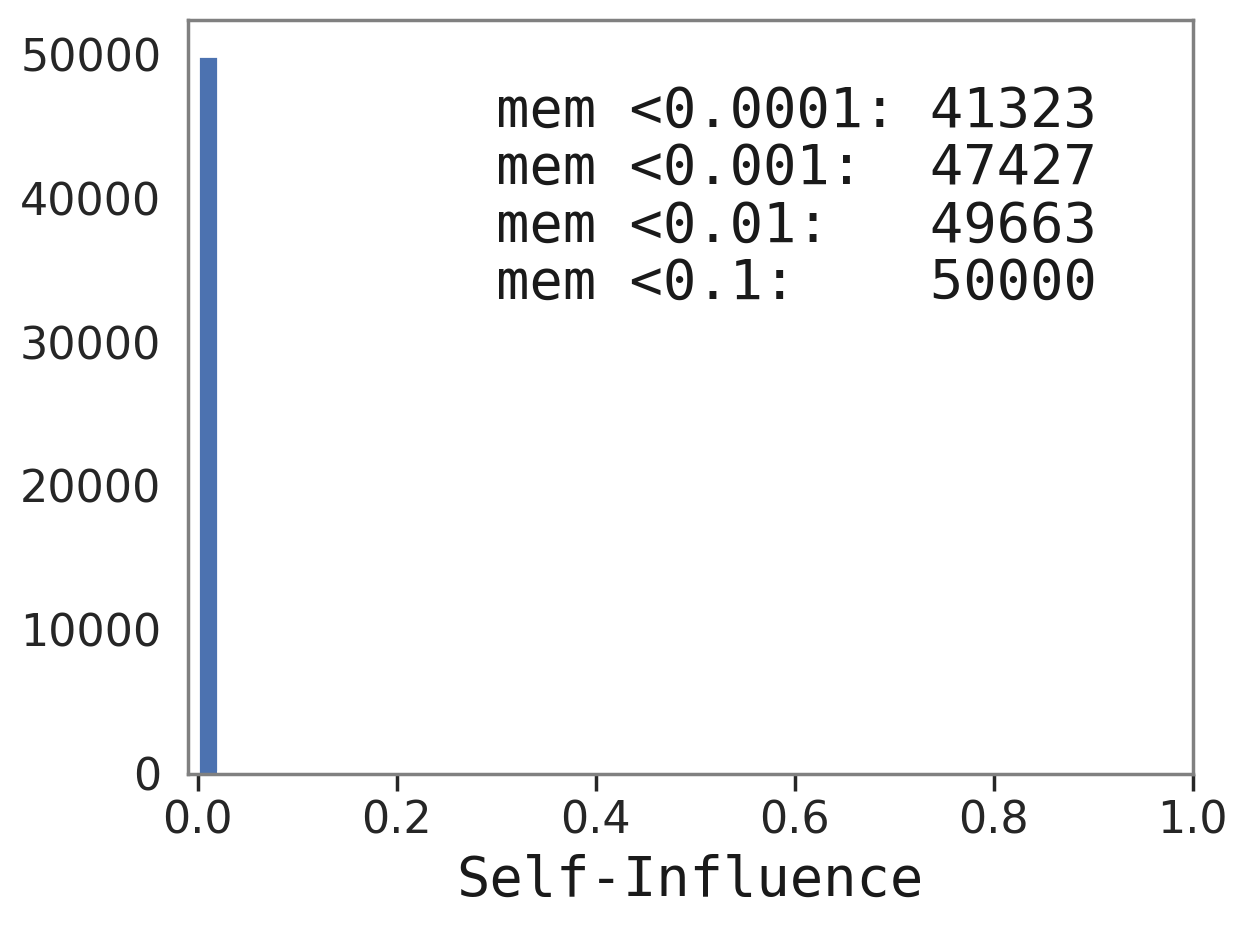

In [ ]:
valid_est_tmp = mem_est.copy()
# valid_est_tmp[(valid_est_tmp<0) & (valid_est_tmp>-0.1) ] = 0
plt.hist(np.abs(valid_est_tmp), bins=3)
plt.text(0.3, 45000, f"mem <0.0001: {(np.abs(valid_est_tmp)<0.0001).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.text(0.3, 41000, f"mem <0.001:  {(np.abs(valid_est_tmp)<0.001).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.text(0.3, 37000, f"mem <0.01:   {(np.abs(valid_est_tmp)<0.01).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.text(0.3, 33000, f"mem <0.1:    {(np.abs(valid_est_tmp)<0.1).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.xlim((-0.01,1))
plt.xlabel("Self-Influence", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/c100_mem_last.pdf")

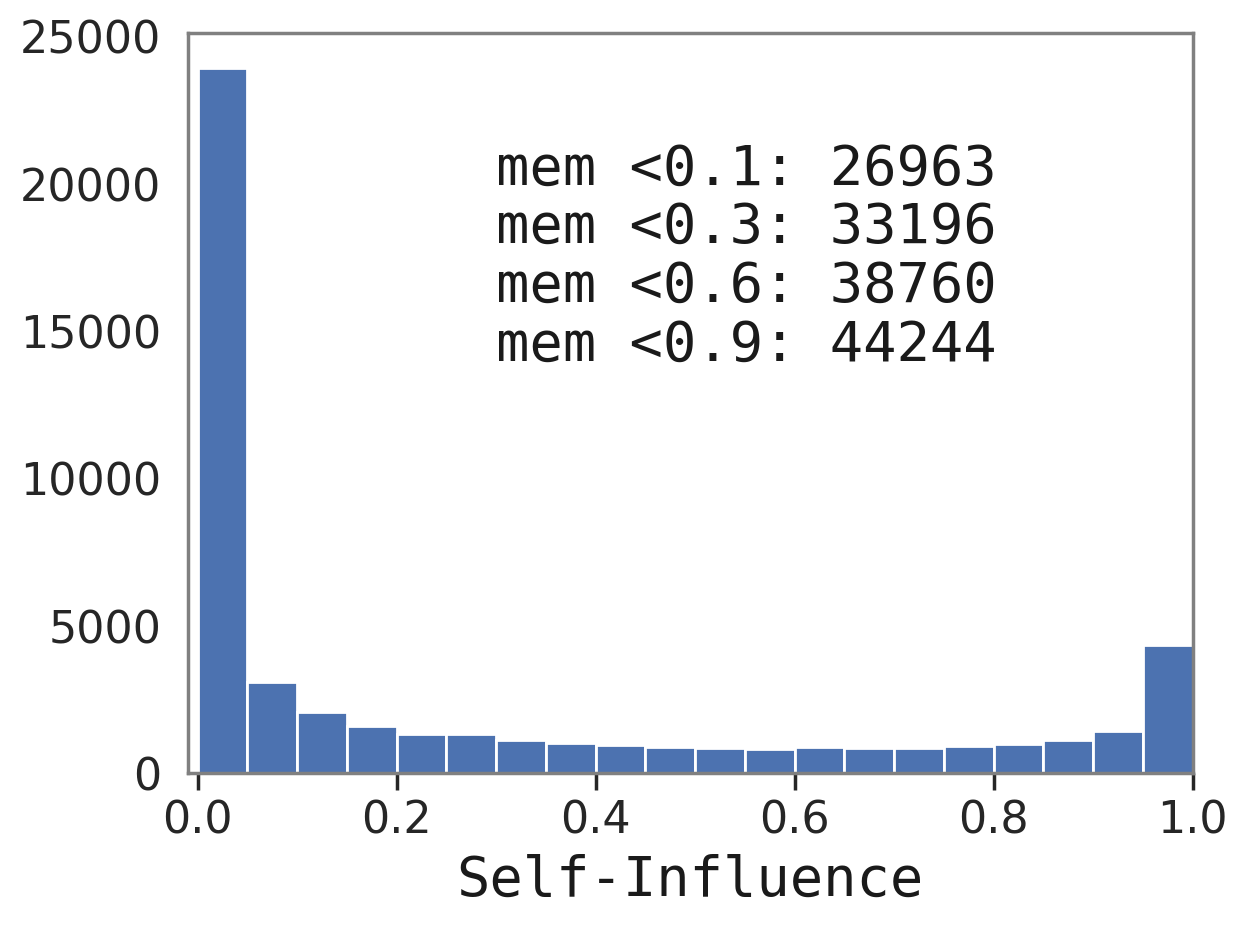

In [ ]:
plt.hist(tr_mem_mp, bins=20)
plt.text(0.3, 20000, f"mem <0.1: {(np.abs(tr_mem_mp)<0.1).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.text(0.3, 18000, f"mem <0.3: {(np.abs(tr_mem_mp)<0.3).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.text(0.3, 16000, f"mem <0.6: {(np.abs(tr_mem_mp)<0.6).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.text(0.3, 14000, f"mem <0.9: {(np.abs(tr_mem_mp)<0.9).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.xlim((-0.01,1))
plt.xlabel("Self-Influence", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/c100_mem_inp.pdf")

In [ ]:
# # uncomment if want to filter on class
# y_tmp = 10  # just one class
# print(f"{label_dict[y_tmp]}, Count: {(Y_test[:500].argmax(axis=1) == y_tmp).sum()}")
# inf_est_tmp = inf_est[:,(Y_test[:500].argmax(axis=1) == y_tmp)]
# inf_est_tmp = inf_est_tmp.T

inf_est_tmp = inf_est.T
print(inf_est_tmp.shape)  # more convenient to use in n_test x n_train format

(500, 50000)


In [ ]:
# class-specific
c = 2
ix_te = np.where(Y_test[:500].argmax(axis=1)==c)[0]
ix_tr = np.where(Y_train.argmax(axis=1)==c)[0]

inf_est_tmp = inf_est_tmp[ix_te,:][:,ix_tr]
inf_est_tmp = inf_est_tmp[:5,:]
print(inf_est_tmp.shape)

(5, 500)


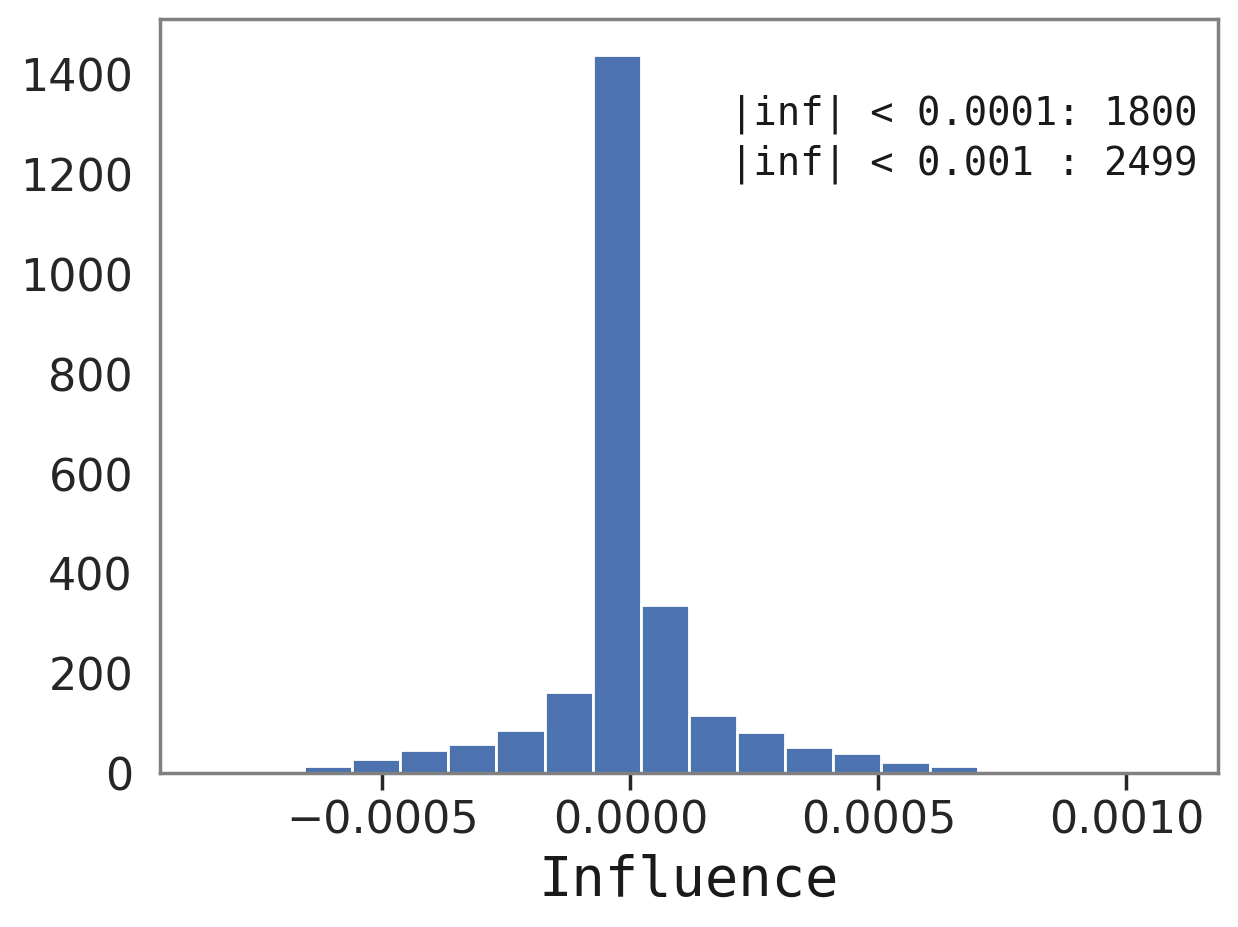

In [ ]:
# Last Layer (all values ~0)

plt.hist(inf_est_tmp.flatten(), bins=20)
plt.text(0.0002, 1300, f"|inf| < 0.0001: {(np.abs(inf_est_tmp)<0.0001).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':14})
plt.text(0.0002, 1200, f"|inf| < 0.001 : {(np.abs(inf_est_tmp)<0.001).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':14})
plt.xlabel("Influence", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/c100_inf5_last_c2.pdf")

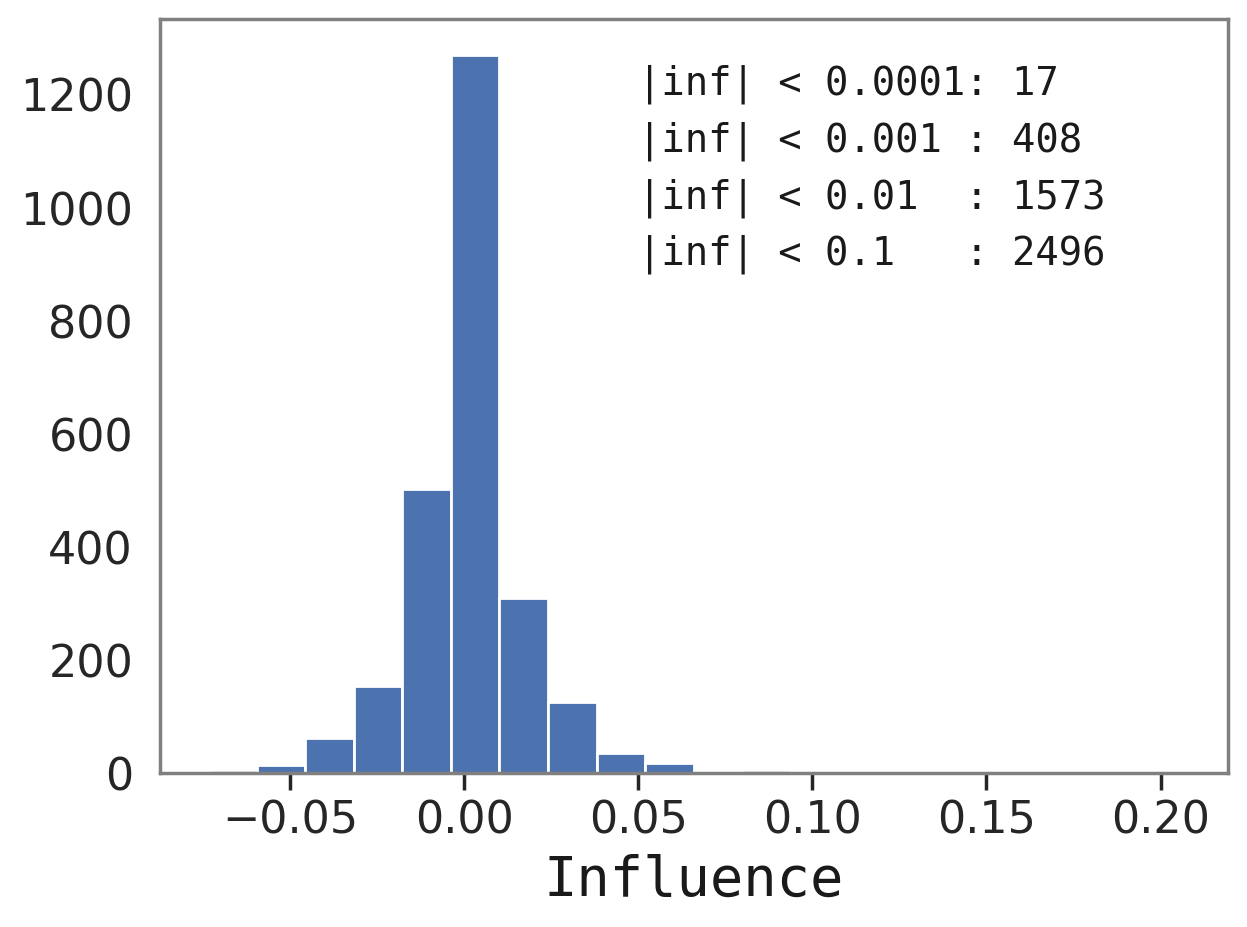

In [ ]:
# Input Layer (larger spread, as expected)

inf_est_tmp = cifar100_infl_matrix_class['infl_matrix_class2']
inf_est_tmp = inf_est_tmp[:,:5].T  # since we run experiments on few instances, let's just share influence results for 5 instances from a particular class
# inf_est_tmp.shape
plt.hist(inf_est_tmp.flatten(), bins=20)
plt.text(0.05, 1200, f"|inf| < 0.0001: {(np.abs(inf_est_tmp)<0.0001).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':14})
plt.text(0.05, 1100, f"|inf| < 0.001 : {(np.abs(inf_est_tmp)<0.001).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':14})
plt.text(0.05, 1000, f"|inf| < 0.01  : {(np.abs(inf_est_tmp)<0.01).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':14})
plt.text(0.05, 900, f"|inf| < 0.1   : {(np.abs(inf_est_tmp)<0.1).sum()}", fontdict={'family':'monospace', 'color':'k', 'size':14})
plt.xlabel("Influence", fontdict={'family':'monospace', 'color':'k', 'size':20})
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/c100_inf5_inp_c2.pdf")